## Introduction
Encouraged by the discrimnatory power of sentence embeddings observed in our preliminary EDA, we set out to train a Neural Network model on these embeddings, along with some other features. We call it TwitterNet. Our trained network performed well, with a Validation set accuracy of 96.3% (using a random split) and 95.3% (using a temporal split). We achieved similar accuracies for our test set.

**The Power of Sentence Embeddings**: To measure the efficacy of sentence embeddings, we conducted an experiment where we substituted the sentence embeddings with Gaussian vectors of same dimension. We did not change the other features (retweets, followers, following). The Neural Net performed poorly with validation accuracy reaching only ~57% by the end of 15 epochs. This confirmed the ability of sentence embeddings to discern among trolls and non-trolls.

**Visualizing Layers of TwitterNet**: To understand how TwitterNet is able to discern between Trolls and Non-Trolls, we visualized the output of three fully connected layers of the network. Specifically, we did a forward pass through our network for about 20k training samples, and visualized the first two principal components of the output produced by each layer. Figure 1 below shows the result. One can observe that when just plot the principal components of inputs, the troll and non-troll data is thoroughly mixed. But as we move from the input layer towards the output layer, each successive layer is able to better separate out trolls from non-trolls. 

**Fig. 1: First Two Principal Components of Outputs of Layers of Trained TwitterNet**
We used Random Train-Test-Val split for this experiment.

<img src="images/layers_random_idx_embed.png" height="600" width="800">


### Data
We used Facebook's InferSent sentence embeddings generator to encode the content of tweets. Our hyperparameter settings include using a vocabulary of 100,000 words, and using the GloVE pre-trained word embeddings. Each sentence was converted into a vector of length $4,096$. 

We concatenated the sentence embedding of each tweet, with three other features (number of 'retweets', number of 'followers', and number of 'following') reulting in an input vector of length $4,099$ which we fed into TwitterNet. We standardized the three additional features using training set mean and standard deviation, before concatenating them with sentence embeddings.

### TwitterNet Architecture
We used a fully connected Neural Network which we implemented in PyTorch. The table below lists out the details:

| Layer Name | Type            | Activation | Input Dimension | Output Dimension |
|------------|-----------------|------------|-----------------|------------------|
| fc1        | Fully Connected | ReLU       | 4099            | 1024             |
| drop1      | Dropout (p=0.7) | -          | 1024            | 1024             |
| fc2        | Fully Connected | ReLU       | 1024            | 512              |
| drop2      | Dropout (p=0.7) | -          | 512             | 512              |
| fc3        | Fully Connected | ReLU       | 512             | 128              |
| fc4        | Fully Connected | -          | 128             | 2                |

The only form of regularization we used for our network was the two DropOut layers with a Drop probability of 0.7. we trained using SGD with momemtum of 0.9 and a learning rate of 0.1.

## Results
### Summary
We trained TwitterNet for 20 epochs for each of random and temporal train-val-test splits. The results are summarized below, and individual experiments follow.

| Method                               | Split Type |No. of Epochs| Train Accuracy | Validation Accuracy | Test Accuracy |
|--------------------------------------|------------|--|----------------|---------------------|---------------|
| Sentence Embeddings  with Neural Net | Random     |20|    96.40%            | 96.30%                     |96.09%               |
| Sentence Embeddings  with Neural Net | Temporal   |20|96.48%                |95.31%                     |95.28%               |
| Random Embeddings  with Neural Net   | Random     |15|   ~75%             |~57%                     |-               |

The last row of the table above shows the results of our experiments when we replaced each $4,096$ long sentence emnbedding with a standard Gaussian vector of same length. We conducted this test to gain confidence in the efficacy of sentence embeddings. As one can observe, the discernability of our Net dropped sharply when we removed the sentence embeddings.

### Accuracy Plots
Below we show the accuracy plots for the three experiments summarized above. Using sentence embeddings, both training and validation accuracies achieved high levels just after 1-2 full iterations over our training set.


**Fig. 2: TwitterNet with Sentence Embeddings and Random Train-Test-Val Split**
<img src="images/random_idx_acc.png" height="300" width="500">

**Fig. 3: TwitterNet with Sentence Embeddings and Temporal Train-Test-Val Split**
<img src="images/temporal_idx_acc.png" height="300" width="500">

**Fig. 4: TwitterNet with Random Gaussian Vectors in place of Sentence Embeddings and Random Train-Test-Val Split**
<img src="images/no_embed_acc.png" height="300" width="500">

## Code

In [1]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import h5py
from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch
import json
import pandas as pd
import glob
import os

import sys
import warnings
warnings.filterwarnings('ignore')

# Pytorch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.insert(0, '/home/paperspace/Twitter/troll_classification/')
# print(sys.path)

In [ ]:
# InferSent setup
from InferSent.models import *
model_version = 1
MODEL_PATH = "../InferSent/encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Keep it on CPU or put it on GPU
use_cuda = True
model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = '../InferSent/dataset/GloVe/glove.840B.300d.txt' if model_version == 1 else '../dataset/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

In [ ]:
def GetEmbeddings(sentences, batch_size=128, verbose=False):
    embeddings = model.encode(sentences, bsize=batch_size, tokenize=False, verbose=verbose)
    if verbose: print('nb sentences encoded : {0}'.format(len(embeddings)))
    return embeddings

def GetBatch(df, feature_cols, response,  batch_size=128):
    '''
    Returns a batch of:
    (1) feature_cols
    (2) the 'content' column which contains text of the tweet
    (3) the response column
    '''
    
    df_size = len(df)
    for counter in range(int(len(df)/batch_size)+1):
        yield df[feature_cols].iloc[counter*batch_size:min((counter + 1)*batch_size, len(df))], \
        df['content'].iloc[counter*batch_size:min((counter + 1)*batch_size, len(df))], \
        df[response].iloc[counter*batch_size:min((counter + 1)*batch_size, len(df))]

## Read Data

In [ ]:
in_file = '../data/merged_troll_data.json'
data_df = pd.read_json(in_file)

In [ ]:
# Describe of whole dataframe
data_df.describe(include='all')

In [ ]:
data_df['troll'] = data_df['troll'].astype(int)

In [ ]:
# Add dummy columns for categorical variables
print('Unique values for column Troll:', data_df.troll.unique())
print('Unique values for column Retweet:', data_df.retweet.unique())
print('Unique values for column Acccount Category:', data_df.account_category.unique())

In [ ]:
dummy_cols = ['account_category']
for col in dummy_cols:
    data_df['Orig_' + col] = data_df[col]
    data_df = pd.get_dummies(data_df, columns=[col])
list(data_df.columns)

In [ ]:
# Set aside columns to be used as features
feature_cols = [
 'followers',
 'following',
 'retweet',
]

In [ ]:
# Read the indices file
index_file = '../data/train_test_inds.json'
idx_df = pd.read_json(index_file)
idx_df.head()

In [ ]:
def PrepareDataSplits(mode='random', batch_size=128, use_random_embed=False):
    TEST_NUM = 0
    TRAIN_NUM = 1
    VAL_NUM = 2
    all_idx = list(idx_df[mode])
    sets = ['test', 'train', 'val']
    
    # Standardize continuous columns based on train set statistics
    all_dfs = {}
    all_dfs['train'] = data_df.iloc[all_idx[TRAIN_NUM]]
    all_dfs['val'] = data_df.iloc[all_idx[VAL_NUM]]
    all_dfs['test'] = data_df.iloc[all_idx[TEST_NUM]]
    
    cols_to_standardize = ['followers', 'following']
    for col in cols_to_standardize:
        train_mean = all_dfs['train'][col].mean()
        train_std = all_dfs['train'][col].std()
        for set_type in sets:
            all_dfs[set_type][col] = (all_dfs[set_type][col] - train_mean)/train_std
    
    # Compute embeddings, concatenate with other features, and write to h5py files
    feature_length = 4096 + len(feature_cols)
    for idx, set_type in enumerate(sets):
        if use_random_embed:
            embed_file = '../data/' + set_type + '_no_embed_mode_' + mode + '.h5py'
        else:
            embed_file = '../data/' + set_type + '_embeddings_mode_' + mode + '.h5py'
        num_tweets = len(all_idx[idx])
        pbar = tqdm(total=num_tweets)
        with h5py.File(embed_file, "a") as f:
            embed_dset = f.create_dataset('features', (num_tweets, feature_length))
            response_dset = f.create_dataset('is_troll', (num_tweets,))
            counter = 0
            for batch in GetBatch(all_dfs[set_type], feature_cols, 'troll', batch_size=batch_size):
                other_features = batch[0].values
                batch_len = other_features.shape[0]
                if use_random_embed:
                    embeddings_ = np.random.randn(batch_len, 4096)
                else:
                    embeddings_  = GetEmbeddings(batch[1].values, batch_size=batch_size)
                is_troll_ = batch[2].values
                
                feature_vec = np.hstack((embeddings_, other_features))
                embed_dset[counter:(counter + batch_len)] = feature_vec
                response_dset[counter:(counter + batch_len)] = is_troll_
                counter += batch_len
                pbar.update(batch_len)

In [3]:
mode = 'temporal'
batch_size = 1024
# PrepareDataSplits(mode=mode, batch_size=batch_size, use_random_embed=True)

In [4]:
# Read h5py file
def GetArrays(mode, set_type, use_random_embed=False):
    if use_random_embed:
        embed_file = '../data/' + set_type + '_no_embed_mode_' + mode + '.h5py'
    else:
        embed_file = '../data/' + set_type + '_embeddings_mode_' + mode + '.h5py'
    with h5py.File(embed_file, "r") as f:
        keys = list(f.keys())
        X = np.array(f[keys[0]])
        y = np.array(f[keys[1]])
    return X, y

In [5]:
X_train, y_train = GetArrays(mode, 'train', use_random_embed=False)
X_val, y_val = GetArrays(mode, 'val', use_random_embed=False)

In [6]:
def ShuffleArrays(X, y):
    arr = np.arange(X.shape[0])
    np.random.shuffle(arr)
    X = X[arr,:]
    y = y[arr]
    return X, y
def GetTrainBatches(X, y, batch_size=256):
    data_len = X.shape[0]
    
    for counter in range(int(data_len/batch_size)+1):
        yield X[counter*batch_size:min((counter + 1)*batch_size, data_len), :], \
        y[counter*batch_size:min((counter + 1)*batch_size, data_len)]

In [7]:
class TwitterNet(nn.Module):
    def __init__(self, num_classes):
        super(TwitterNet, self).__init__()
        self.fc1 = nn.Linear(4099,1024)
        self.drop1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
X_train = Variable(torch.FloatTensor(X_train))
y_train = Variable(torch.FloatTensor(y_train))
X_val = Variable(torch.FloatTensor(X_val))
y_val = Variable(torch.FloatTensor(y_val))

In [9]:
criterion = nn.CrossEntropyLoss()
model_net = TwitterNet(2).to(device)
optimizer = SGD(model_net.parameters(), lr = 0.1, momentum=0.9)
num_epochs = 20
batch_size = 1024

In [10]:
# Check accuracy on untrained network (with randomly initialized weights)
torch.set_grad_enabled(False)
running_corrects = 0
for inputs, labels in GetTrainBatches(X_val, y_val, batch_size):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_net(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.long().data)
val_acc = running_corrects.double()/X_val.shape[0]
torch.set_grad_enabled(True)
print('Validation Accuracy on untrained net is {:.2%}'.format(val_acc))

Validation Accuracy on untrained net is 23.74%


In [11]:
torch.set_grad_enabled(True)
train_acc_hist = []
val_acc_hist = []
for epoch in range(num_epochs):
    X_train, y_train = ShuffleArrays(X_train, y_train)
    running_loss = 0.0
    train_corrects = 0
    
    for inputs, labels in GetTrainBatches(X_train, y_train, batch_size):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model_net(inputs)
        loss = criterion(outputs, labels.long())
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.long().data)
        
        # backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Validation set accuracy
    train_acc = train_corrects.double()/X_train.shape[0]
    torch.set_grad_enabled(False)
    running_corrects = 0
    for inputs, labels in GetTrainBatches(X_val, y_val, batch_size):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_net(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.long().data)
    val_acc = running_corrects.double()/X_val.shape[0]
    train_acc_hist += [train_acc]
    val_acc_hist += [val_acc]
    torch.set_grad_enabled(True)
    print('Loss after epoch {} is {:.3f}. Train Acc. is {:.2%} and Validation Acc. is {:.2%}'.\
          format(epoch+1, running_loss, train_acc, val_acc))

Loss after epoch 1 is 78.958. Train Acc. is 85.01% and Validation Acc. is 94.04%
Loss after epoch 2 is 30.638. Train Acc. is 95.81% and Validation Acc. is 94.75%
Loss after epoch 3 is 29.235. Train Acc. is 95.94% and Validation Acc. is 94.51%
Loss after epoch 4 is 30.943. Train Acc. is 95.68% and Validation Acc. is 91.69%
Loss after epoch 5 is 31.550. Train Acc. is 95.52% and Validation Acc. is 93.89%
Loss after epoch 6 is 30.326. Train Acc. is 95.71% and Validation Acc. is 95.52%
Loss after epoch 7 is 29.282. Train Acc. is 95.83% and Validation Acc. is 94.36%
Loss after epoch 8 is 29.124. Train Acc. is 95.82% and Validation Acc. is 94.70%
Loss after epoch 9 is 27.676. Train Acc. is 96.02% and Validation Acc. is 94.57%
Loss after epoch 10 is 27.187. Train Acc. is 96.05% and Validation Acc. is 94.81%
Loss after epoch 11 is 26.036. Train Acc. is 96.24% and Validation Acc. is 94.99%
Loss after epoch 12 is 26.116. Train Acc. is 96.22% and Validation Acc. is 94.97%
Loss after epoch 13 is 25

In [12]:
# Check accuracy on trained network
torch.set_grad_enabled(False)
running_corrects = 0
for inputs, labels in GetTrainBatches(X_val, y_val, batch_size):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_net(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.long().data)
val_acc = running_corrects.double()/X_val.shape[0]
torch.set_grad_enabled(True)
print('Validation Accuracy on trained net is {:.2%}'.format(val_acc))

Validation Accuracy on trained net is 95.31%


In [13]:
# Test Set
X_test, y_test = GetArrays(mode, 'test')

In [14]:
X_test = Variable(torch.FloatTensor(X_test))
y_test = Variable(torch.FloatTensor(y_test))

# Check test accuracy on trained network
torch.set_grad_enabled(False)
running_corrects = 0
for inputs, labels in GetTrainBatches(X_test, y_test, batch_size):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_net(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.long().data)
test_acc = running_corrects.double()/X_test.shape[0]
torch.set_grad_enabled(True)
print('Test Accuracy on trained net is {:.2%}'.format(test_acc))

Test Accuracy on trained net is 95.28%


In [15]:
# See how the model separates
num_batches = 20
batch_size = 1024
torch.set_grad_enabled(False)
l1, l2, l3 = None, None, None
all_in = None
all_labels = None
for i in range(num_batches):
    inputs, labels = next(GetTrainBatches(X_train, y_train, batch_size))
    inputs = inputs.to(device)
    labels = labels.to(device)

    layer1_out = F.relu(model_net.fc1(inputs))
    layer2_out = F.relu(model_net.fc2(layer1_out))
    layer3_out = F.relu(model_net.fc3(layer2_out))
    
    if all_in is None: all_in = inputs.cpu().numpy()
    else:              all_in = np.vstack((all_in, inputs.cpu().numpy()))
    
    if l1 is None: l1 = layer1_out.cpu().numpy()
    else:          l1 = np.vstack((l1, layer1_out.cpu().numpy()))
    
    if l2 is None: l2 = layer2_out.cpu().numpy()
    else:          l2 = np.vstack((l2, layer2_out.cpu().numpy()))
        
    if l3 is None: l3 = layer3_out.cpu().numpy()
    else:          l3 = np.vstack((l3, layer3_out.cpu().numpy()))
        
    if all_labels is None: all_labels = labels.cpu().numpy()
    else:                  all_labels = np.hstack((all_labels, labels.cpu().numpy()))
torch.set_grad_enabled(True)

In [16]:
# PLot prin components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [17]:
pca_in = PCA(n_components=2)
pca_in.fit(all_in)
print('Variance explained by first two components for inputs is ', pca_in.explained_variance_ratio_)
tfm_in = pca_in.transform(all_in)

pca1 = PCA(n_components=2)
pca1.fit(l1)
print('Variance explained by first two components for layer 1 is ', pca1.explained_variance_ratio_)
tfm_l1 = pca1.transform(l1)

pca2 = PCA(n_components=2)
pca2.fit(l2)
print('Variance explained by first two components for layer 2 is ', pca2.explained_variance_ratio_)
tfm_l2 = pca2.transform(l2)

pca3 = PCA(n_components=2)
pca3.fit(l3)
print('Variance explained by first two components for layer 3 is ', pca3.explained_variance_ratio_)
tfm_l3 = pca3.transform(l3)

Variance explained by first two components for inputs is  [0.13639076 0.08243444]
Variance explained by first two components for layer 1 is  [0.4066578  0.17972784]
Variance explained by first two components for layer 2 is  [0.7510138  0.22605978]
Variance explained by first two components for layer 3 is  [0.9592463 0.0393222]


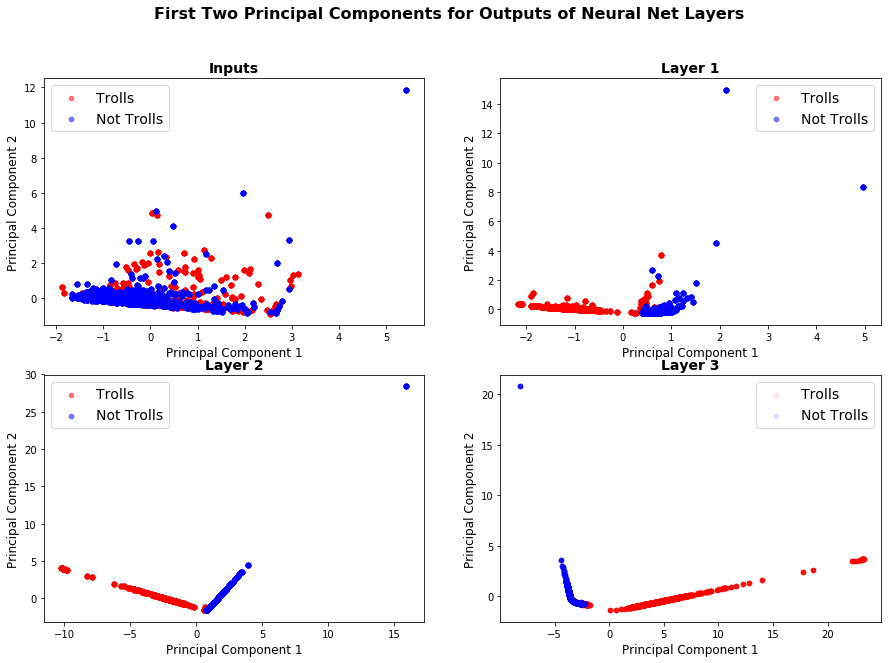

In [18]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 10)
s = 20
alpha = 0.5
_ = ax[0,0].set_title('Inputs', fontsize=14, weight='bold')
_ = ax[0,0].scatter(tfm_in[all_labels == 1, 0], tfm_in[all_labels == 1, 1], label='Trolls', s=s, alpha=alpha, color='red', marker='o')
_ = ax[0,0].scatter(tfm_in[all_labels == 0, 0], tfm_in[all_labels == 0, 1], label='Not Trolls', s=s, alpha=alpha, color='blue', marker='o')


_ = ax[0,1].set_title('Layer 1', fontsize=14, weight='bold')
_ = ax[0,1].scatter(tfm_l1[all_labels == 1, 0], tfm_l1[all_labels == 1, 1], label='Trolls', s=s, alpha=alpha, color='red', marker='o')
_ = ax[0,1].scatter(tfm_l1[all_labels == 0, 0], tfm_l1[all_labels == 0, 1], label='Not Trolls', s=s, alpha=alpha, color='blue', marker='o')

_ = ax[1,0].set_title('Layer 2', fontsize=14, weight='bold')
_ = ax[1,0].scatter(tfm_l2[all_labels == 1, 0], tfm_l2[all_labels == 1, 1], label='Trolls', s=s, alpha=alpha, color='red', marker='o')
_ = ax[1,0].scatter(tfm_l2[all_labels == 0, 0], tfm_l2[all_labels == 0, 1], label='Not Trolls', s=s, alpha=alpha, color='blue', marker='o')

_ = ax[1,1].set_title('Layer 3', fontsize=14, weight='bold')
_ = ax[1,1].scatter(tfm_l3[all_labels == 1, 0], tfm_l3[all_labels == 1, 1], label='Trolls', s=s, alpha=0.1, color='red', marker='o')
_ = ax[1,1].scatter(tfm_l3[all_labels == 0, 0], tfm_l3[all_labels == 0, 1], label='Not Trolls', s=s, alpha=0.1, color='blue', marker='o')

for i in range(2):
    for j in range(2):
#         _ = ax[i,j].set_xlim(-3, 3)
#         _ = ax[i,j].set_ylim(-3, 3)
        _ = ax[i,j].set_xlabel('Principal Component 1', fontsize=12)
        _ = ax[i,j].set_ylabel('Principal Component 2', fontsize=12)
        _ = ax[i,j].legend(loc='best', fontsize=14)
fig.suptitle('First Two Principal Components for Outputs of Neural Net Layers', fontsize=16, weight='bold')
fig.savefig('layers_temporal_idx_embed.png')

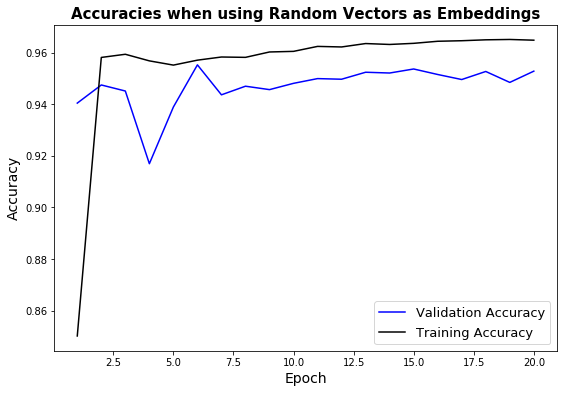

In [19]:
# Plot loss curves
fig = plt.gcf()
fig.set_size_inches(9, 6)
_ = plt.plot(np.arange(num_epochs)+1, val_acc_hist, label='Validation Accuracy', color='blue')
_ = plt.plot(np.arange(num_epochs)+1, train_acc_hist, label='Training Accuracy', color='k')
_ = plt.legend(loc='best', fontsize=13)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Accuracy', fontsize=14)
_ = plt.title('Accuracies when using Random Vectors as Embeddings', fontsize=15, weight='bold')
fig.savefig('temporal_idx_acc.png')